In [7]:
try:
    import os
    import pandas as pd
    import numpy as np
    from scipy.stats import randint
    import seaborn as sns # used for plot interactive graph.
    import matplotlib.pyplot as plt
    import seaborn as sns
    from io import StringIO
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.feature_selection import chi2
    from IPython.display import display
    from sklearn.model_selection import train_test_split
    from sklearn.feature_extraction.text import TfidfTransformer
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import LinearSVC
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import confusion_matrix
    from sklearn import metrics
except Exception as e:
    print("Error : {} ".format(e))

In [13]:
df1 = pd.read_excel('output_final.xlsx')
print(df1.shape)

(17305, 3)


In [14]:
df1.head(3).T

,0,1,2
report,firefox with sync prefs.js is ansi instead utf-8,show tab favicons immediately,Icon looks pixelated on gnome3
cat,Backend,Frontend,Frontend
class,1,2,2


In [15]:
pd.DataFrame(df1.cat.unique()).values

array([['Backend'],
       ['Frontend'],
       ['Security'],
       ['Documentation'],
       ['Performance']], dtype=object)

In [16]:
df2 = df1.sample(5000, random_state=1).copy()

In [17]:
# Create a new column 'category_id' with encoded categories
df2['category_id'] = df2['cat'].factorize()[0]
category_id_df = df2[['cat', 'category_id']].drop_duplicates()
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'cat']].values)
# New dataframe
df2.head()

,report,cat,class,category_id
13700,Add new notification settings for priority bas...,Documentation,4,0
5377,Add automated test for sort ordering in new Mi...,Backend,1,1
11248,Custom email sender per project,Backend,1,1
4836,Download tool is opened in background when cli...,Frontend,2,2
4755,"On narrow screenshot selections, middle handle...",Frontend,2,2


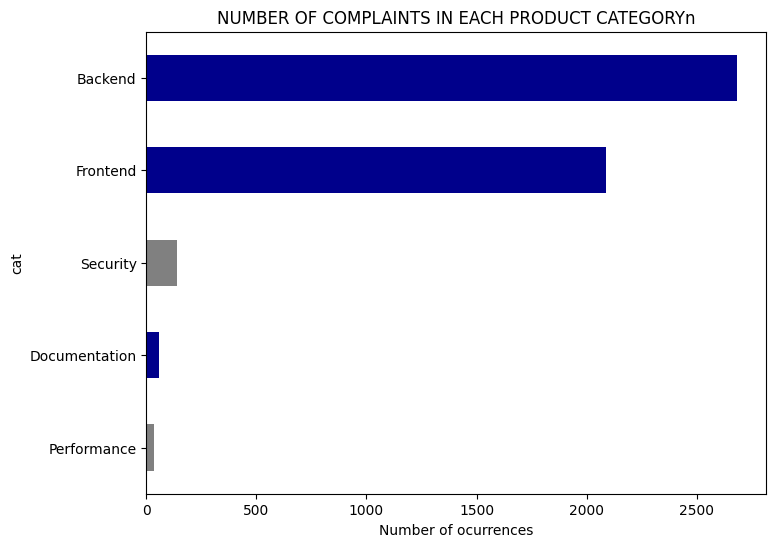

In [24]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','darkblue','grey','darkblue', 'darkblue']
df2.groupby('cat').report.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORYn')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [25]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')
# We transform each complaint into a vector
features = tfidf.fit_transform(df2.report).toarray()
labels = df2.category_id
print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 5000 complaints is represented by 1621 features (TF-IDF score of unigrams and bigrams)


In [28]:
# Finding the three most correlated terms with each of the report categories
N = 3
for cat, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("n==> %s:" %(cat))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

n==> Backend:
  * Most Correlated Unigrams are: menu, tab, email
  * Most Correlated Bigrams are: email notification, email notifications, rest api
n==> Documentation:
  * Most Correlated Unigrams are: guide, installation, documentation
  * Most Correlated Bigrams are: custom field, wiki page, redmine installation
n==> Frontend:
  * Most Correlated Unigrams are: menu, email, tab
  * Most Correlated Bigrams are: email notifications, context menu, rest api
n==> Performance:
  * Most Correlated Unigrams are: slow, replace, performance
  * Most Correlated Bigrams are: redmine stable, editing issues, projects api
n==> Security:
  * Most Correlated Unigrams are: cert, certificate, private
  * Most Correlated Bigrams are: browsing mode, private window, private browsing


In [30]:
X = df2['report'] # Collection of documents
y = df2['cat'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.15,
                                                    random_state = 0)

In [31]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [32]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8422,0.006760
LogisticRegression,0.8372,0.007050
MultinomialNB,0.8326,0.006189
RandomForestClassifier,0.6218,0.007259


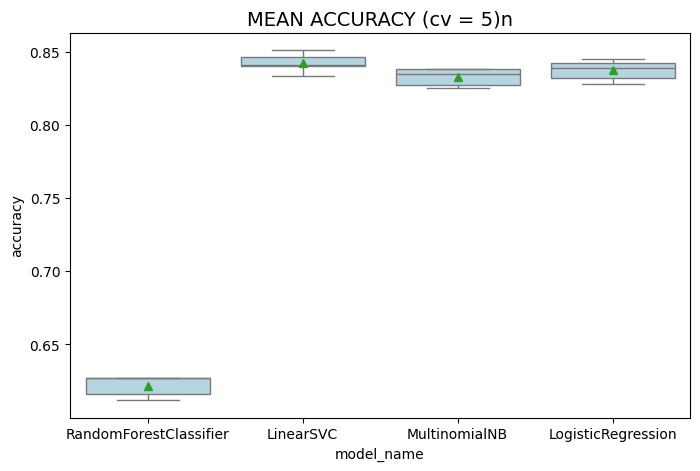

In [33]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)n", size=14);

In [34]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,
                                                               labels,
                                                               df2.index, test_size=0.15,
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [35]:
# Classification report
print('CLASSIFICATIION METRICSn')
print(metrics.classification_report(y_test, y_pred,
                                    target_names= df2['cat'].unique()))

CLASSIFICATIION METRICSn
               precision    recall  f1-score   support

Documentation       0.67      0.22      0.33         9
      Backend       0.85      0.89      0.87       388
     Frontend       0.83      0.84      0.83       325
     Security       0.73      0.35      0.47        23
  Performance       0.00      0.00      0.00         5

     accuracy                           0.83       750
    macro avg       0.61      0.46      0.50       750
 weighted avg       0.83      0.83      0.83       750



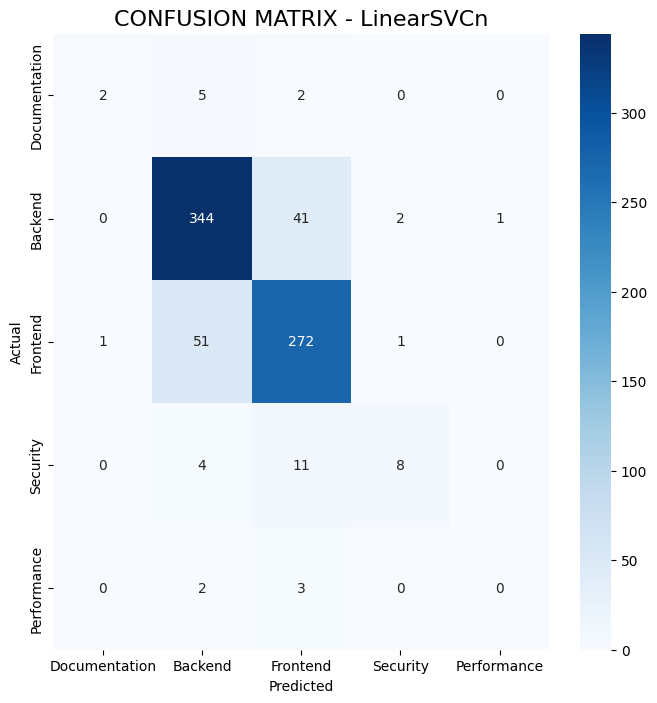

In [36]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.cat.values,
            yticklabels=category_id_df.cat.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVCn", size=16);

In [37]:
#prediction ( Testing )
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.15,
                                                    random_state = 0)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')
fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [43]:
report = "We have a problem in the main menu image, we need to center it in the screen."
print(model.predict(fitted_vectorizer.transform([report])))

report = "We have a problem in the sending email to customers."
print(model.predict(fitted_vectorizer.transform([report])))

# report = "we can not understand any line from the code, need to add some documentation"
# print(model.predict(fitted_vectorizer.transform([report])))

['Frontend']
['Backend']
['Documentation']
